In [1]:
import numpy as np
import pandas as pd 
import math
import matplotlib.pyplot as plt
import itertools
import random
import statistics
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

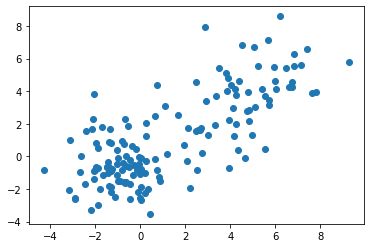

In [2]:
data_clu = pd.read_table('C:/Users/User/Desktop/USC/Machine Learning/HW2/clusters.txt',sep=',',
                         header = None,names = ['x','y'])
plt.scatter(data_clu['x'],data_clu['y'])

In [3]:
def kmeans (data,numb_k,numb_update,min_x,max_x,min_y,max_y):

#Randomly assign the initial centroids
 centroids = random.sample(list(itertools.product(range(min_x, max_x), range(min_y, max_y))), numb_k)    

 for _ in range(numb_update):
    
    #Calculate the distances to centroids from each data entity:
    dist = np.zeros((data.shape[0],numb_k))
    for i in range(len(data)):
        for j in range(len(centroids)):
            dist[i,j] = np.linalg.norm(data.iloc[i]-centroids[j]) 
        
    #Find the nearest centroid:
    near_cen = np.zeros((data.shape[0],1)) 
    near_cen = np.argmin(dist,1) 
    
    #Update centroids 
    for cen_i in range(numb_k):
        centroids[cen_i] = np.mean(data[near_cen==cen_i])
 
 #Add to the original data frame the cluster each entity belongs to 
 data_with_cluster = data.join(pd.DataFrame(near_cen,columns=['cluster']),how='outer')

 return centroids,data_with_cluster

In [4]:
#Use the three clusters after 2 times k-means algorithm as the initial three Gaussian distributions

centroids,data_with_cluster = kmeans (data_clu,3,2,-5,10,-5,10)

In [5]:
#Split the dataset into three sub-datasets which respectively belongs to one Gaussian distribution 
df1 = data_with_cluster.loc[data_with_cluster['cluster']==0]

df2 = data_with_cluster.loc[data_with_cluster['cluster']==1]

df3 = data_with_cluster.loc[data_with_cluster['cluster']==2]

data_GMM = pd.read_table('C:/Users/User/Desktop/USC/Machine Learning/HW2/clusters.txt',sep=',',
                         header = None)

In [6]:
#Calculate the means for each gaussian distribution, store them into a 3x2 matrix:mu_init
mu1x = np.mean(df1['x'])

mu1y = np.mean(df1['y'])

mu1 = [mu1x,mu1y]


mu2x = np.mean(df2['x'])

mu2y = np.mean(df2['y'])

mu2 = [mu2x,mu2y]


mu3x = np.mean(df3['x'])

mu3y = np.mean(df3['y'])

mu3 = [mu3x,mu3y]


mu_init = [mu1,mu2,mu3]

In [8]:
mu_init

[[-1.0433076421111116, -0.7587137140864197],
 [3.0666090424, 0.31425916840000007],
 [4.487370214722222, 4.158145118444446]]

In [10]:
#Calculate the covariances for each gaussian distribution, store them into a 3x2 matrix:mu_init
cov1 = np.cov(df1['x'],df1['y'],bias=True)

cov2 = np.cov(df2['x'],df2['y'],bias=True)

cov3 = np.cov(df3['x'],df3['y'],bias=True)

cov_init=[cov1,cov2,cov3]

In [11]:
cov_init

[array([[ 1.06406595, -0.14404994],
        [-0.14404994,  1.68344745]]),
 array([[2.04838852, 0.09566045],
        [0.09566045, 0.88812692]]),
 array([[4.54367265, 1.51332539],
        [1.51332539, 2.69878114]])]

In [12]:
#Calculate each data entity's initial weights on three Gaussian distributions
weights_init = np.ones((data_clu.shape[0], 3)) / 3 

#pi:The proportion of all data entities on each Gaussian distribution 
pi0 = weights_init.sum(axis=0) / weights_init.sum() 


In [15]:
#Initialize the E-step:
#Updating the weights:

def update_weight (data,mu,cov,k,pi):
    pdf= np.zeros((data.shape[0],k))
    weights = np.zeros((data.shape[0],k))
    for i in range(k):
        pdf[:,i] = (pi[i])*multivariate_normal.pdf(x=data,mean=mu[i],cov=cov[i]) 

    weights = pdf/np.sum(pdf,axis=1).reshape(-1,1)
    
    return(weights)  

#Get the new weights(frequency) of each data entity on different Gaussian distributions 

In [16]:
#Update pi:the proportion of all data entities in each Gaussian distribution

def update_pi(weight):
    new_pi = weight.sum(axis=0)/weight.sum()
    return new_pi   

In [17]:
#Initialize the M-step:
#Updating the Gaussian parameters:average,variance,covariance and the covariance matrix 

def update_gaussian (data,weight,k):  
    new_mu = np.zeros((k,2))  
    new_var = np.zeros((k,2))
    new_cov_matrix = [] 
    new_cov = [] 
    
    for i in range(k):
        new_mu[i] = (np.average(data,axis=0,weights=weight[:,i]))
        
        new_var[i] = np.average((data - new_mu[i]) ** 2, axis=0, weights=weight[:, i])
        
        new_cov_matrix.append(weight[:,i]*(data-new_mu[i]).dot((data-new_mu[i]).T))
    
        new_cov.append(np.dot(((weight.T)[i].reshape(len(data),1) * 
                               (data - new_mu[i])).T, (data - new_mu[i])) / (np.sum((weight.T)[i])))
       
    return new_mu,new_var,new_cov_matrix,new_cov

In [46]:
#Plot the Gaussian 2-d projection on the data scattergram 
def plot(data,mu,var,k):
    plt.figure()
    plt.axis([-5,10,-5,10])
    plt.scatter(data[0],data[1])
    color=['red','blue','lime']   
    for i in range(k):
        for j in range(4):
            gaussian = Ellipse(mu[i],width= j * math.sqrt(var[i][0]), 
                               height=j * math.sqrt(var[i][1]),edgecolor=color[i],
                               **{'fc': 'None','ls': '--'})
            (plt.gca()).add_patch(gaussian)

[[ 4.24991441  3.29982988]
 [-0.90756622 -0.07103146]
 [-1.13775638 -1.32294287]]
[[4.06408712 5.05720279]
 [0.82687279 2.26675992]
 [1.50015373 0.79570872]]
[array([[4.06408712, 2.42856463],
       [2.42856463, 5.05720279]]), array([[ 0.82687279, -0.6418151 ],
       [-0.6418151 ,  2.26675992]]), array([[1.50015373, 0.22436344],
       [0.22436344, 0.79570872]])]
[          0         1         2         3         4          5         6    \
0    0.754120  0.984618  0.728978  0.260328  1.649106  21.772799  3.195326   
1    0.791158  1.032978  0.765083  0.273154  1.730164  22.842730  3.354685   
2    0.495064  0.646637  0.522539  0.176760  1.091902  14.377802  2.449989   
3    0.791700  1.033837  0.791546  0.276797  1.736833  22.908159  3.564775   
4    0.505288  0.659754  0.492637  0.174988  1.105848  14.596619  2.174593   
..        ...       ...       ...       ...       ...        ...       ...   
145 -0.237725 -0.310680 -0.280295 -0.088793 -0.530533  -6.960475 -1.411802   
146 -0.0

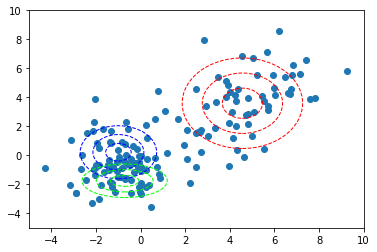

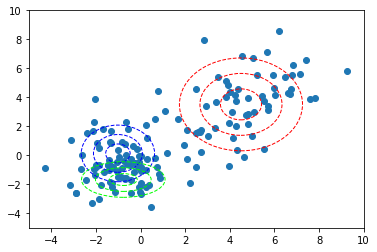

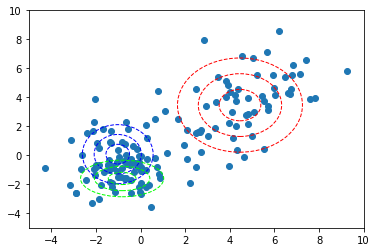

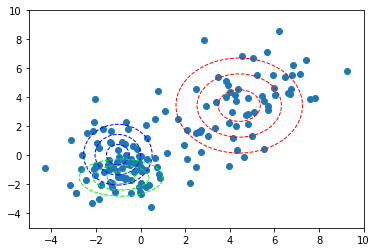

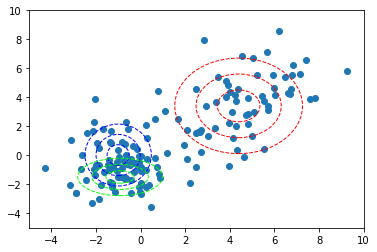

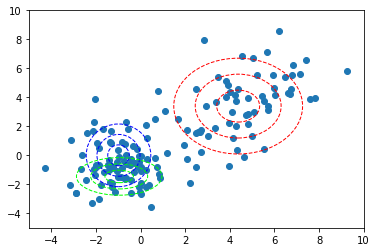

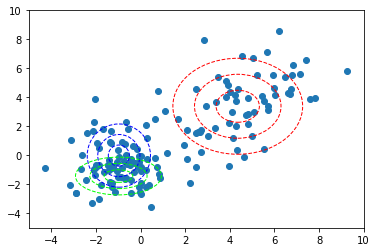

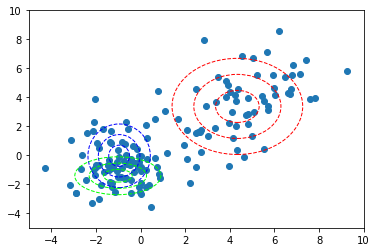

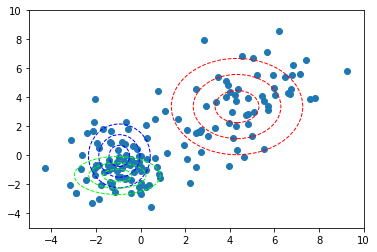

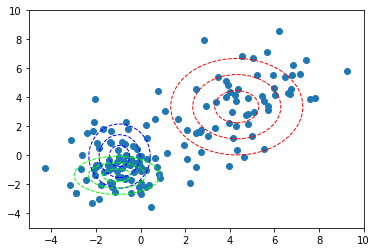

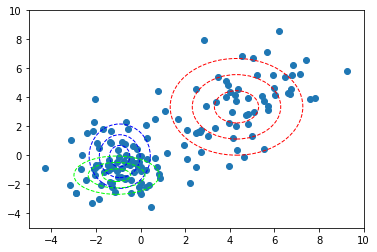

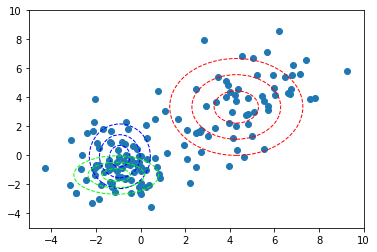

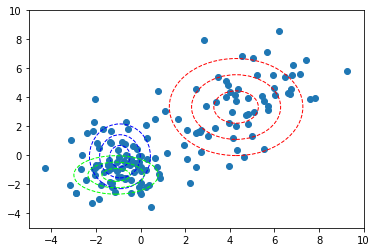

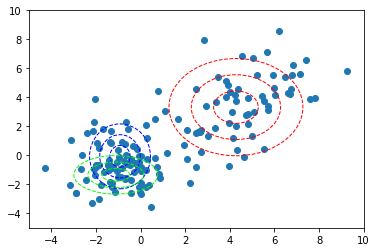

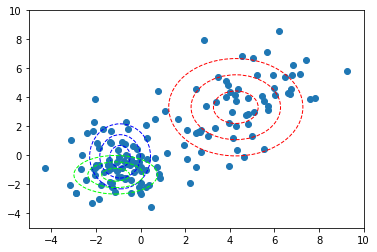

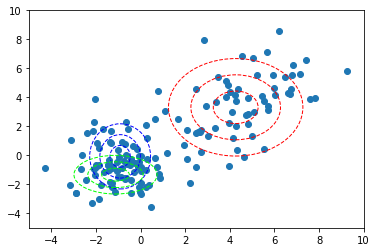

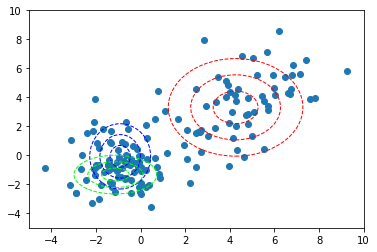

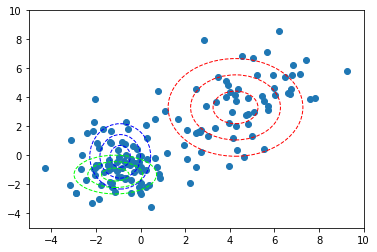

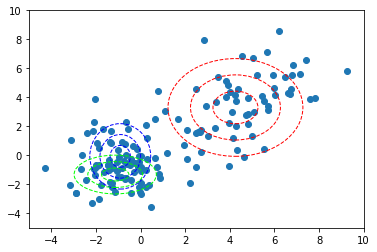

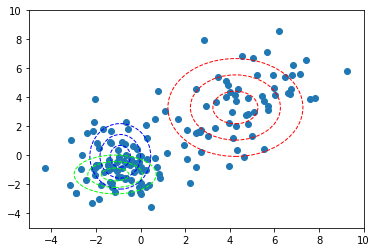

In [48]:
#Call the main functions, doing the EM algorithm 20 times 

if __name__ == '__main__':
    data = data_GMM
    mu = mu_init 
    cov = cov_init 
    k = 3
    pi = pi0
    weight = weights_init
    for i in range(20):
        weight = update_weight(data,mu,cov,k,pi)
        pi = update_pi(weight)
        mu,var,cov_matrix,cov=update_gaussian (data,weight,k)
        plot(data,mu,var,k)
     
    print(mu)
    print(var)
    print(cov)
    print(cov_matrix)
 
 
      